In [8]:
import os
import sys
sys.path.append('../') 

def import_config(folderpaths:str="heat"):
    abspath = "/cluster/scratch/shiwen/GNPDESolver"
    folderpaths = os.path.join(abspath, folderpaths)
    filenames = os.listdir(folderpaths)
    configpaths = []
    for filename in filenames:
        if filename.endswith(".json"):
            configpaths.append(os.path.join(folderpaths, filename))
    return configpaths

In [10]:
foldername = "config/lano/fd/finetune/wave_layer"
filenames = import_config(foldername)
filenames.append("/cluster/scratch/shiwen/GNPDESolver/config/lano/others/full/wave_layer.json")
print(f"num configs:{len(filenames)}")
for filename in filenames:
    print(filename)

num configs:8
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/fd_128.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/wave_layer_256.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/wave_layer_128.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/fd_512.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/fd_1024.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/wave_layer_512.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/fd_256.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/others/full/wave_layer.json


In [21]:
from main import FileParser
args     = []
for filename in filenames:
    print(filename)
    arg  = FileParser(filename).parse_args()
    args.append(arg)  

/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/fd_128.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/wave_layer_256.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/wave_layer_128.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/fd_512.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/fd_1024.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/wave_layer_512.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/fd/finetune/wave_layer/fd_256.json
/cluster/scratch/shiwen/GNPDESolver/config/lano/others/full/wave_layer.json


In [25]:
from pathlib import Path

def get_custom_name_from_path(path):
    # 获取文件名不带扩展名
    filename = Path(path).stem

    if filename.startswith("fd_"):
        number = filename.split('_')[1]
        return f"RippleNet-{number}"
    elif filename.startswith("wave_layer_"):
        number = filename.split('_')[2]
        return f"Lano-{number}"
    elif filename == "wave_layer":
        return "Lano-1024"
    else:
        return "Unknown"  

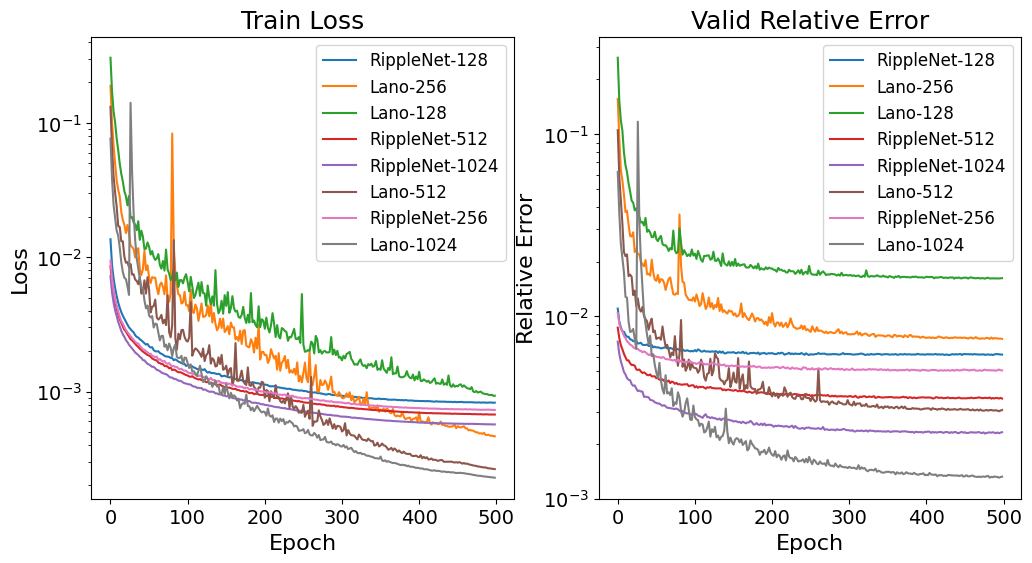

In [31]:
# plot losses
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns  
import numpy as np
import os


def as_abs_path(_path):
    if not os.path.isabs(_path):
        _path = os.path.join(
            os.path.abspath(os.path.dirname(os.getcwd())),
            _path
            )
    return _path


loss_df = []

for arg in args:
    loss_path = arg.path["loss_path"][:-4]+".npz"
    loss_path = as_abs_path(loss_path)
    data = np.load(loss_path)
    train_loss = data["losses"]
    valid_loss = data["val_losses"]  

    loss_df.append(pd.DataFrame.from_dict({
        'epoch':np.concatenate([
                np.arange(len(train_loss))*arg.optimizer["args"]["eval_every_eps"], 
                np.arange(len(valid_loss))*arg.optimizer["args"]["eval_every_eps"]
                ]),
        'loss' :np.concatenate([train_loss,valid_loss]),
        'loss_type': np.concatenate([
                np.repeat("train", len(train_loss)), 
                np.repeat("valid", len(valid_loss))
                ]),
        'gnn':np.repeat(get_custom_name_from_path(arg.path["loss_path"]), len(train_loss)+len(valid_loss))
    }))
loss_df = pd.concat(loss_df)


one_axes = False 

if one_axes:
    # plot in one axes
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(data=loss_df, hue='gnn', x='epoch', y='loss', style='loss_type', ax=ax)
    ax.set_yscale('log')
    plt.show()

else:
    # plot in two axes
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    train_df = loss_df[loss_df['loss_type']=='train']
    valid_df = loss_df[loss_df['loss_type']=='valid']
    sns.lineplot(data=train_df, hue='gnn', x='epoch', y='loss', ax=ax[0])
    sns.lineplot(data=valid_df, hue='gnn', x='epoch', y='loss', ax=ax[1])
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[0].set_title('Train Loss', fontsize=18)
    ax[1].set_title('Valid Relative Error', fontsize=18)
    ax[0].legend(fontsize=12)
    ax[1].legend(fontsize=12)
    ax[0].set_xlabel('Epoch', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=16)
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[1].set_ylabel('Relative Error', fontsize=16)
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    plt.show()

#fig.savefig("abla_process_loss.pdf")